# Detect Reflected DLL injection attacks using Machine Learning



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import precision_recall_fscore_support

import time
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# ------------ Load the dataset -------------------- #
data = pd.read_csv("Final_dataset.csv")
print(data.shape)
print(data.OS.unique())
# ------------ End Loading dataset ----------------- #

(85019, 10)
['win10' 'win7' 'win8.1']


# Features:

1. **OS - Operating System** - 
This attribute describes the operating system where the data was collected.  In this dataset, it is either Windows 10, Windows 8.1, or Windows 7.

2. **ModuleCount** -
This is the number of distinct modules, or dlls, that are loaded into process memory.

3. **HandleCount** -
This is the number of operating system handles the process has opened.

4. **PagedSystemMemorySize64** -
This is the amount of paged system memory allocated for a process.

5. **PeakVirtualMemorySize64** -
This is the maximum amount of virtual memory that has been used by a process.

6. **ProcessName** - 
This is the name of a process.  The ModuleList attribute, when included, lists the executable as the first module loaded.

7. **WorkingSet** -
This is the current memory usage of the process.

8. **ThreadCount** -
This is the number of running threads in a selected process.

9. **Injected** - 
Boolean, true if the process has been injected, false if not.



### Data Preprocessing

In [ ]:
# --------- Check for Null values ----------- #
print(data.isnull().sum())

# If there are more null values, consider replacing than removing records
data = data.dropna()

# Display the final number of rows and columns
print(data.shape) 

Unnamed: 0                 0
OS                         0
ModuleCount                0
HandleCount                0
PagedSystemMemorySize64    0
PeakVirtualMemorySize64    0
ProcessName                0
WorkingSet                 0
ThreadCount                0
Injected                   0
dtype: int64
(85019, 10)


In [ ]:
# Displaying Injected and Non-injected Processes
injected = data[data['Injected']==1]

print("---------------------------\n","Total Unique Processes:",
      "\n---------------------------\n")
print(data['ProcessName'].value_counts())

# This provides an insight on:
# - Which process was injected the most
# - Processes that have few number of occurance can be regarded as unseen data
print("\n---------------------------\n","Most injected Processes:",
      "\n---------------------------\n")
print(injected.ProcessName.value_counts())

---------------------------
 Total Unique Processes: 
---------------------------

svchost                  56861
dwm                       1700
lsass                     1514
winlogon                  1501
spoolsv                   1477
vmicsvc                   1451
conhost                   1099
wlms                       995
SMSvcHost                  964
WUDFHost                   946
LogonUI                    919
fontdrvhost                803
explorer                   797
ruby                       695
VBoxService                689
SearchProtocolHost         603
wininit                    599
cygrunsrv                  596
csrss                      591
sshd                       587
SearchIndexer              580
IntelCpHeciSvc             522
ibtsiva                    520
RzSDKServer                519
GameScannerService         515
RzSDKService               514
IntelCpHDCPSvc             513
igfxCUIService             508
wlanext                    508
TeamViewer_Service

In [ ]:
# --------- Converting categorical features to numeric ----------- #
data['ProcessName'] = data['ProcessName'].astype('category').cat.codes
data['OS'] = data['OS'].astype('category').cat.codes
X = data[['OS','ModuleCount','HandleCount','PagedSystemMemorySize64',
          'PeakVirtualMemorySize64','ProcessName','WorkingSet','ThreadCount']]
Y = data['Injected']

# Detecting Outliers using LOF

In [ ]:
lof = LocalOutlierFactor(n_neighbors=3)
lof_predict = lof.fit_predict(X)
outlier = 0
for t in lof_predict:
  if t ==-1:
    outlier+=1

print("Number of outliers predicted: ",outlier)

decision_lof_neg = lof.negative_outlier_factor_

count = 0
positive = 0
for x in decision_lof_neg:
  if x <=-40:
    count+=1

print("Number of data-points that have smaller than or equal to -40: ",count)

Number of outliers predicted:  16658
Number of data-points that have smaller than or equal to -40:  7105


## Supervised Learning algorithms for prediction

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,
                                                    random_state=37)

print("Train set: ", X_train.shape,"  Test Set: ",X_test.shape)
print("Train label: ", y_train.shape,"  Test label: ",y_test.shape)

Train set:  (68015, 8)   Test Set:  (17004, 8)
Train label:  (68015,)   Test label:  (17004,)


## Applying KNN to the dataset

We find the number of optimum neighbors by iterating through the algorithm for different values of n.

In [ ]:
highest_recall =0
h_n=0

train_time_knn = 0
for n in range(3,10):
  knn_model = KNeighborsClassifier(n_neighbors=n)
  start_time = time.time()
  knn_model.fit(X_train, y_train)
  train_time_knn += time.time()-start_time
  y_predict = knn_model.predict(X_test)
  true_neg, false_pos, false_neg, true_pos = confusion_matrix(y_test,y_predict).ravel()
  Accuracy = (true_pos+true_neg)/(true_pos+true_neg+false_pos+false_neg)
  Precision = true_pos/(true_pos+false_pos)
  Recall = true_pos/(true_pos+false_neg)
  if Recall>highest_recall:
    highest_recall=Recall
    h_n = n
  print("For n: ",n,"\nAccuracy: ",Accuracy,"\nPrecision: ",Precision,"\nRecall: ",Recall)

avg_train_time_knn = round((train_time_knn/7),2) 
print("\nHighest recall achieved: ",highest_recall," at n: ",h_n)
print("Average training time: ",avg_train_time_knn,"seconds")

For n:  3 
Accuracy:  0.9900023523876735 
Precision:  0.9865494739645758 
Recall:  0.9907716998796309
For n:  4 
Accuracy:  0.9897671136203247 
Precision:  0.9900684471882969 
Recall:  0.9866256519994651
For n:  5 
Accuracy:  0.9892378263937897 
Precision:  0.9848444562616325 
Recall:  0.9907716998796309
For n:  6 
Accuracy:  0.988238061632557 
Precision:  0.9871468737448119 
Recall:  0.9860906780794436
For n:  7 
Accuracy:  0.987414725946836 
Precision:  0.9829764596355899 
Recall:  0.9884980607195399
For n:  8 
Accuracy:  0.9864149611856033 
Precision:  0.9842288158246458 
Recall:  0.9848869867593955
For n:  9 
Accuracy:  0.9860621030345801 
Precision:  0.9822808419930722 
Recall:  0.9860906780794436

Highest recall achieved:  0.9907716998796309  at n:  3
Average training time:  0.12 seconds


# Random Forest Classifier

In [ ]:
model = RandomForestClassifier(n_estimators=40)
scores = cross_val_score(model, X_train, y_train, scoring = 'recall', cv = 5)
scores

array([0.99917314, 0.99950397, 0.99950397, 0.9985119 , 0.99966931])

In [ ]:
start_time = time.time()
model.fit(X_train,y_train)
train_time_rfc = round((time.time()-start_time),2)
pred = model.predict(X_test)
true_neg, false_pos, false_neg, true_pos = confusion_matrix(y_test,pred).ravel()
Accuracy = (true_pos+true_neg)/(true_pos+true_neg+false_pos+false_neg)
Precision = true_pos/(true_pos+false_pos)
Recall = true_pos/(true_pos+false_neg)
print("Accuracy: ",Accuracy,"\nPrecision: ",Precision,"\nRecall: ",Recall)


Accuracy:  0.9988238061632557 
Precision:  0.997996527314011 
Recall:  0.9993312825999733


## SVM - SVC

Using 5 fold cross validation with SVM-SVC model to find the average accuracy achieved on the training dataset. And then applying a fitted model to test dataset to validate its actual performance for predictions.

In [ ]:
X_train.shape

(68015, 8)

In [ ]:
clf = SVC(kernel='rbf', C=1)
print("Generating Scores . . ")
scores = cross_val_score(clf, X_train, y_train, cv=5)
print(scores)

Generating Scores . . 
[0.55546571 0.55539219 0.55539219 0.55539219 0.55539219]


In [ ]:
# Use the best fit kernel k
svm_svc = SVC(kernel='rbf', C=1)
start_time = time.time()
svm_svc.fit(X_train,y_train)
train_time_svc = time.time()-start_time
pred = svm_svc.predict(X_test)
precision_recall_fscore_support(y_test, pred, average='micro')

(0.5602799341331451, 0.5602799341331451, 0.5602799341331451, None)

In [ ]:
train_time_svc = round(train_time_svc,2)
train_time_svc

296.35

## Semi-Supervised Learning

In [ ]:
Labeled_x, Test_x, Labeled_y, Test_y = train_test_split(X, Y, test_size=0.9,
random_state=37, shuffle=True)

def getRatio(data_y):
  injected = 0
  clean = 0
  for l in data_y:
    if l == 1:
      injected+=1
    elif l == 0:
      clean+=1
  return [clean,injected]

labeled_ratio = getRatio(Labeled_y)
unlabeled_ratio = getRatio(Test_y)
print("Clean/Injected ratio in Labeled Dataset: ",
      labeled_ratio[0],"/",labeled_ratio[1])
print("Clean/Injected ratio in Unabeled Dataset: ",
      unlabeled_ratio[0],"/",unlabeled_ratio[1])


Clean/Injected ratio in Labeled Dataset:  4783 / 3718
Clean/Injected ratio in Unabeled Dataset:  42520 / 33998


In [ ]:
X_test.shape

(17004, 8)

In [ ]:
models = [LinearSVC(),NuSVC(),SVC(kernel='rbf'),SGDClassifier(),NearestCentroid(), 
          RandomForestClassifier(n_estimators=40),KNeighborsClassifier(n_neighbors=3)]
train_time_supervised = []
train_time_semi = []
Unlabeled_x = X_test.iloc[:]

for model in models:
  model.seed = 42
  model_name = type(model).__name__
  start_time = time.time()
  # Fit the model on the labeled dataset 
  model.fit(X_train,y_train)
  train_time_supervised.append(round((time.time()-start_time),2))
  # Predict the 
  Y_test = model.predict(Unlabeled_x)
  
  Unlabeled_x['Type'] = Y_test
  
  # Create Pseudo Labels by selecting first 10000 predicted samples
  pseudo_X = Unlabeled_x.iloc[:10000,:-1]
  pseudo_Y = Unlabeled_x.iloc[:10000,-1]
  
  # Merge the labeled and pseudo labeled datasets
  X = [Labeled_x,pseudo_X]
  Y = [Labeled_y,pseudo_Y]
  x_merged = pd.concat(X)
  y_merged = pd.concat(Y)

  # Printing the size of merged dataset for each model to ensure we have the
  # right number of records i.e 10000 + size of labeled set
  # print("Merged X: ",x_merged.shape," Merged Y: ",y_merged.shape)

  # Evaluate the model using cross-fold validation
  scores = cross_val_score(model,x_merged,y_merged,cv=5,
                           scoring='neg_root_mean_squared_error')
  rmse = " %0.2f (+/- %0.2f)" % (np.sqrt(scores.mean()*-1),
                                              scores.std() * 2)
  print('{model} CV-5 RMSE: {score}'.format(model=model.__class__.__name__, 
                                            score=rmse))
  
  # Applying the semi-supervised model on the dataset
  start_time = time.time()
  model.fit(x_merged,y_merged)
  train_time_semi.append(round((time.time()-start_time),2))
  pred = model.predict(Test_x)
  semi_scores = precision_recall_fscore_support(Test_y, pred, average='micro')
  print('{model}, Precision {precision}, Recall {recall} \n'.format(model=model.__class__.__name__, 
                                            precision=semi_scores[0],recall=semi_scores[0]))

  # Reset the X_test (unlabeled data) for the next model
  Unlabeled_x = X_test.iloc[:]

LinearSVC CV-5 RMSE:  0.75 (+/- 0.21)
LinearSVC, Precision 0.44431375624036173, Recall 0.44431375624036173 

NuSVC CV-5 RMSE:  0.78 (+/- 0.46)
NuSVC, Precision 0.5329726338900651, Recall 0.5329726338900651 

SVC CV-5 RMSE:  0.67 (+/- 0.00)
SVC, Precision 0.5556862437596383, Recall 0.5556862437596383 

SGDClassifier CV-5 RMSE:  0.72 (+/- 0.06)
SGDClassifier, Precision 0.44431375624036173, Recall 0.44431375624036173 

NearestCentroid CV-5 RMSE:  0.62 (+/- 0.51)
NearestCentroid, Precision 0.5329726338900651, Recall 0.5329726338900651 

RandomForestClassifier CV-5 RMSE:  0.20 (+/- 0.01)
RandomForestClassifier, Precision 0.9981442275020257, Recall 0.9981442275020257 

KNeighborsClassifier CV-5 RMSE:  0.36 (+/- 0.02)
KNeighborsClassifier, Precision 0.9818735460937296, Recall 0.9818735460937296 



As seen in the above results, lower the RMSE better the model performance. Random Forest and KNN classifiers work. We will thus fit the model on the smaller merged dataset containing labeled and pseudo labeled records. This will allow us to save time required for training the model without affecting the accuracy, precision and recall.

Also note that our test dataset here is the remaining 90% of the data in contrast to the previous 20% test data.

# Plotting Graphs

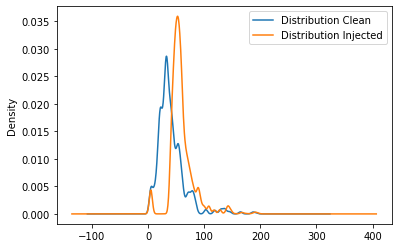

In [ ]:
df_clean = data[data.Injected == 0]                            
df_injected = data[data.Injected == 1]

leg = ['Distribution Clean', 'Distribution Injected']
s = pd.Series(df_clean["ModuleCount"])
t = pd.Series(df_injected["ModuleCount"])
ax = s.plot.kde()
ax = t.plot.kde()
plt.legend(leg)
plt.savefig("./module_distribution.png", bbox_inches='tight')


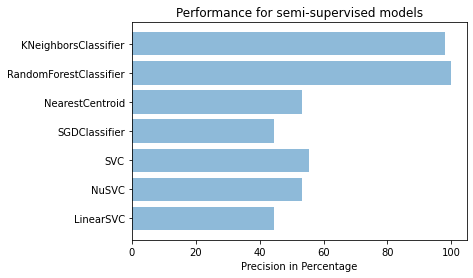

In [ ]:
# LinearSVC CV-5 RMSE:  0.75 (+/- 0.21)
# LinearSVC, Precision 0.44431375624036173, Recall 0.44431375624036173 

# NuSVC CV-5 RMSE:  0.78 (+/- 0.46)
# NuSVC, Precision 0.5329726338900651, Recall 0.5329726338900651 

# SVC CV-5 RMSE:  0.67 (+/- 0.00)
# SVC, Precision 0.5556862437596383, Recall 0.5556862437596383 

# SGDClassifier CV-5 RMSE:  0.72 (+/- 0.06)
# SGDClassifier, Precision 0.44431375624036173, Recall 0.44431375624036173 

# NearestCentroid CV-5 RMSE:  0.62 (+/- 0.51)
# NearestCentroid, Precision 0.5329726338900651, Recall 0.5329726338900651 

# RandomForestClassifier CV-5 RMSE:  0.20 (+/- 0.01)
# RandomForestClassifier, Precision 0.9981442275020257, Recall 0.9981442275020257 

# KNeighborsClassifier CV-5 RMSE:  0.36 (+/- 0.02)
# KNeighborsClassifier, Precision 0.9818735460937296, Recall 0.9818735460937296

precision = [44.4,53.3,55.6,44.4,53.3,99.8,98.1]

labels = ['LinearSVC','NuSVC','SVC','SGDClassifier',
          'NearestCentroid','RandomForestClassifier','KNeighborsClassifier']

y_pos = np.arange(len(labels))

plt.barh(y_pos, precision, align='center', alpha=0.5)
plt.yticks(y_pos, labels)
plt.xlabel('Precision in Percentage')
plt.title('Performance for semi-supervised models')
plt.show()